# Precision

## Precision indicates how much additional behavior the process model allows that is not seen in the event log. It therefore compares the state space of the tree execution while replaying the log.

#### Importing Libs

In [1]:
import os
import configparser
from datetime import date
import pandas as pd
import re
import graphviz
import math
import seaborn as sns
import collections

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from itertools import permutations 

mpl.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

from tqdm import tqdm
from tqdm import trange


#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

from scipy.stats import sem
pd.set_option('display.max_rows', 10000)

#### Profit Intialization

In [2]:
PATH = 'C:\\Users\\ashis\\Python Notebooks\\ProFIT'# path to ProFIT directory
config = configparser.ConfigParser()
config.add_section("packageLocation")
config.set("packageLocation", "workingDir", PATH)
config.set("packageLocation", "packageDir", PATH+'\\profit')


import sys
sys.path.append(config["packageLocation"]["workingDir"])
sys.path.append(config["packageLocation"]["packageDir"])


from profit import ProcessMap
pm = ProcessMap()

## Net Graph GENERATOR

In [3]:
def MINER(in_data, act, path):

    pm.set_log(data = in_data)
          
    # Have to change "Optimize" State when using Manual Path & Activity Rates
    pm.set_params(optimize = False, aggregate = False) # Optimize = TRUE/FALSE # Agg_type = inner/outer
        
        
    # Will be activated only when "OPTIMIZE" from above is changed to "False"
    pm.set_rates(activity_rate = act, path_rate = path ) # Rates = Activity & Path rate only 
       
    # Logic on this (or in % , where 100% means complete utilization & 0% Vice Versa) 
    # Activity Rate = The precision/clarity of the model/graph being produced (i.e. when at 100 = all events are displayed, when at 5-10 low number of events with the most highest weightage are displayed)
    # Path rate = the regulation of paths (i.e. aggregation of path in %)0 = high aggregation of path, 100 % super detailed paths to every case/task
        
    pm.update() # Updates settings
        
    # pm.render() # Renders the Final Process Model
        
    print(pm.get_rates())
        
    net = pm.get_graph()
   
    return net### Net Graph GENERATOR 

### Filters, Finalizer & Character Sorter*

*Character Sorter is for Ease of Operation

In [4]:
def Filter(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub('-', '', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:','', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'','', temp)
        temp = re.sub('\.','', temp)
        temp = re.sub(' +', '', temp)
        temp = re.sub('"', '', temp)
        return temp

def inner_Filter(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
                
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'','', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', '', temp)
        temp = re.sub('-', "",temp)
        return temp
    

    
def Final(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        HT = pd.DataFrame([x.split(' ') for x in temp.split('\n')])
        HT = HT.transpose()
        HT = HT.drop([0]).reset_index(drop = True)
        HT.columns = ['Task']
        HT= HT.drop(index=HT.index[-1])
        HT = HT.drop_duplicates(ignore_index=True)
        HT = HT.sort_values("Task").reset_index(drop = True)
        #print(HT)
    
        return HT 
    
# Letter Sorter
def char_sorter(DA_LIST):
    # BUBBLE SORT
    li = DA_LIST.tolist()
    l = len(DA_LIST)
    temp = []
    
    for i in range(l):
        for j in range(l-i-1):
            if li[j]>li[j+1]:
                temp = li[j]
                li[j] = li[j+1]
                li[j+1] = temp
                
    return li

def START_END_DEL(mainkey, subkey):
    
    SS = pd.DataFrame(subkey,mainkey).reset_index()
    SS.columns = ["mainkey", "subkey"]
    
    flag = []

    for i in range(len(SS)):
        if SS["mainkey"][i]=='start':
            flag.append(i)
        elif SS["subkey"][i] == 'end':
            flag.append(i)
    
    SS = SS.drop(flag).reset_index(drop = True)
    
    r_mainkey = list(SS["mainkey"])
    r_subkey = list(SS["subkey"])
    
    return (r_mainkey, r_subkey)


### DataSets

In [5]:
df = pd.read_csv("remote_monitoring_eng.csv")
df1 = df[df['task'] != 'New med program operator']
df1 = df1.reset_index(drop = True)
df1

,case_id,task,timestamp
0,4082,Red zone operator,2018-01-10 22:09:21
1,4082,Red zone doctor FD,2018-01-12 02:44:28
2,4173,Red zone operator,2018-01-12 11:16:53
3,4176,Red zone operator,2018-01-12 11:49:30
4,4176,Red zone doctor FD,2018-01-12 11:49:50
...,...,...,...
35353,9155,Notification operator,2018-12-31 09:03:14
35354,9362,Notification operator,2018-12-31 09:03:16
35355,9758,Notification operator,2018-12-31 09:03:23
35356,9938,Notification operator,2018-12-31 09:03:26


### IDs in the DataSet

In [6]:
ids = df1["case_id"].unique()
ids

array([ 4082,  4173,  4176,  4187,  4191,  4217,  5265,  4388,  4392,
        4422,  4454,  4401,  4476,  4553,  4494,  4545,  4521,  4539,
        4511,  4562,  4554,  4564,  4583,  4626,  4757,  4838,  4842,
        4837,  4844,  4914,  4868,  4960,  4982,  5079,  5095,  5159,
        5085,  5298,  5301,  5226,  5335,  5294,  5322,  5329,  5355,
        5361,  5389,  5372,  5376,  5441,  5443,  5424,  5457,  5534,
        5558,  5568,  5601,  5410,  5706,  5699,  5717,  5750,  5752,
         830,  5854,  5834,  5903,  5915,  5924,  5952,  5938,  5961,
        6013,  6044,  6061,  6141,  6187,  6233,  6230,  6241,  6293,
        6325,  6331,  6343,  6334,  6378,  6338,  6351,  6412,  6457,
        6502,  6503,  6522,  6563,  6545,  6616,  6632,  6649,  6659,
        6736,  6744,  6718,  6826,  6818,  6840,  6884,  6912,  6943,
        7012,  7005,  7025,  7015,  7064,  7054,  7060,  7129,  7125,
        7122,  7136,  7144,  7194,  7184,  7188,  7192,  7218,  7277,
        7321,  7313,

### Prefixing

In [6]:
for j in trange(len(df1)):
    df1["task"][j] = Filter(df1["task"][j])

  0%|                                                                                       | 0/150291 [00:00<?, ?it/s]C:\Users\ashis\AppData\Local\Temp\ipykernel_1700\2075314714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["task"][j] = Filter(df1["task"][j])
100%|████████████████████████████████████████████████████████████████████████| 150291/150291 [00:22<00:00, 6750.23it/s]


### Precision Calculation - Activity Rate - varied / Path Rate - Constant

In [18]:
#ACT = []
PATH = []
PREC_FINAL = []

PATH_THRES = [5,20,40,60,80,100]

for holy_j in trange(len(PATH_THRES)):
    
    #ACT = []
    PATH = []
    PREC_FINAL = []
    
    INDI_FIT = []
    fitter = 0
    
    
    THE_FATHERLOAD = []
    
    COV_COV = 0
    ID = []
    LOG_LEN = []
    MAP_LEN = []
    FIT_STS = []
    COV_MAP = []
    
    
    for count in trange(0,101,1): #101
        
        keys = [] # To store Initial keys 
    
        mainkey = [] # Source Keys
        subkey = [] # Destination Keys 
        
        startindex = 0 # To store START keyword index
        endindex = 0 # To store END keyword Index
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Net Assignment 
        INPUT = MINER(df1, count, PATH_THRES[holy_j])#count # The Process MAP that is to be compared is entered here (Dataset is entered here)
        #------------------------------------------------------------------------------------------------------------------------
    
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Assigning key to main List 
        for key in INPUT:
            #print(key)
            keys.append(key)
        #-------------------------------------------------------------------------------------------------------------------------
        
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Key Segregation 
        for i in range(len(keys)):
            T1 = keys[i]
            T2 = inner_Filter(T1)
            T3 = T2.split(' ')
            mainkey.append(T3[0])
            subkey.append(T3[1])  
        #-------------------------------------------------------------------------------------------------------------------------
    
        
        #-------------------------------------------------------------------------------------------------------------------------    
        
        # DELETION of START & END Keyword
        
        mainkey, subkey = START_END_DEL(mainkey,subkey)
    #-------------------------------------------------------------------------------------------------------------------------
    
    
    #-------------------------------------------------------------------------------------------------------------------------
        t_i = mainkey[0]
        k=0
        a = collections.defaultdict(list)
        
        while k < len(mainkey):
            # dynamically create key
            if k == 0:
                key = mainkey[k]
                
            if t_i == mainkey[k]:
                value = subkey[k]
                a[key].append(value)
                k+=1
            else:
                if t_i != mainkey[k]:
                    t_i = mainkey[k]
                    key = mainkey[k]
                    value = subkey[k]
                    a[key].append(value)
                    k+=1
    #-------------------------------------------------------------------------------------------------------------------------
    # 'a' is the variable which stores the INFO about connections
        
    #-------------------------------------------------------------------------------------------------------------------------
       # The MODEL REMAINS THE PAME THROHGOUT BUT THE TRACES & DATA LOGS CHANGE THROUGH OUT.
        # CHECKING THAT EACH TRACE FITS WITHIN THE PROCESS MODEL
            # Creation of the MATRIX FROM 
        T = []
        T = pd.DataFrame(mainkey) # The ROWS
        TT = T[0].unique()
        TT.tolist()# FROM  SOURCE
            
        Q = []
        Q = pd.DataFrame(subkey) # COLUMNS
        QQ = Q[0].unique()
        QQ.tolist() # DESTINATION FINAL

        # Matrix is created here & RESET
        d = 0
        d = pd.DataFrame(0, index = char_sorter(TT), columns=char_sorter(QQ)) # Initialzing Matrix 
            # Accessing the Matrix d.loc["a","a"]
    
    
    
            # Entering the Values to the Matrix
        keyer = list(a.keys()) # SOURCE - FROM # USING A Here
        
        for ii in range(len(a)):
            for jj in range(len(a[keyer[ii]])):        
                d.loc[keyer[ii], a[keyer[ii]][jj]] = 1       
            
            
    
            # A Python program to print all 
    
    
    
        #keyer = list(a.keys()) # SOURCE - FROM
        #COMPARE = ""
        COMPARE2 = ""
        #COMPARE3 = ""
    
        
        for ii in range(len(d.index)):
            for jj in range(len(d.columns)):
                            if d.loc[d.index[ii], d.columns[jj]] == 1:
                                #print(d.index[ii], d.columns[jj])
                                #COMPARE = COMPARE + d.index[ii] + d.columns[jj]
                                COMPARE2 = COMPARE2 + d.index[ii] + d.columns[jj] + " "
                                #COMPARE = COMPARE + d.index[ii] + d.columns[jj] + ""
            
        COMPARE2 = COMPARE2.upper()
        COMPARE2_1 = pd.DataFrame(list(COMPARE2.split(" ")))
        CC = COMPARE2_1[0].unique()
            
        index = np.argwhere(CC=="")
        CC = np.delete(CC,index)
    
        
    #-------------------------------------------------------------------------------------------------------------------------
    # The Process Model is compared with each Trace and the final Precision is calculated per trace vs the Overall Process model
    # This is because we use the Generalized Process model and not Individual in this case
    
    
        final_state = 0 # SHOULD BE REFRESHED FOR EVERY ITERATION OF THE PROCESS MODEL (i.e. every new process map & not every ID)
        SUM_PREC = 0
        
        test_id = []
        test_PREC = []
        
        creation5 = []
        COMBI5 = []
        
        for s in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID
            
            df3 = df1[df1["case_id"]== ids[s]].reset_index(drop = True)
        
            trace = df3.copy() # ID CARRYING VARIABLE
            
            
    
                # LOG
        # Creation of Synthetic Paris for Comparison
        ### The pairs here are created using the DATA LOG = Directly from the Data Logs and not the 

            # INDEPENDENT OF ANY OTHER CALCULATIONS
    
            ###  First Combo EVEN COMBO 

        # WHOLE AS A UNIT

            creation2 = ""
    
            for kk in range(1, len(trace["task"]),2):
                #print(df1["task"][kk-1], df1["task"][kk])
                creation2 = creation2+trace["task"][kk-1]+trace["task"][kk]+" "
        
            F = pd.DataFrame(list(creation2.split(" ")))
            #len(F[0].unique())
            COMBI2 = F[0].unique() # FIRST PAIR COMBO 
    
    
            ### Second Combo ODD COMBO
    
            creation3 = ""
        
            for kk in range(1, len(trace["task"])-1,2):
                #print(df1["task"][kk-1], df1["task"][kk])
                creation3 = creation3+trace["task"][kk]+trace["task"][kk+1]+" "
        
            C = pd.DataFrame(list(creation3.split(" ")))
            #len(C[0].unique())
            COMBI3 = C[0].unique()
    
            # Combining both
            creation4 = np.concatenate((COMBI2,COMBI3))
            M = pd.DataFrame(list(creation4))
            COMBI4 = M[0].unique()
    
    
            index = np.argwhere(COMBI4=="")
            COMBI4 = np.delete(COMBI4,index)
            
            
            index = np.argwhere(COMBI4=="")
            COMBI4 = np.delete(COMBI4,index)
            
            
            #COMBI5.append(COMBI4)
        
            for gg in range(len(COMBI4)):
                creation5.append(COMBI4[gg])
            
            GG = pd.DataFrame(creation5)
            COMBI5 = GG[0].unique()
        
    #del creation5
    #del GG
            
            PRECISION = 1-len(np.setdiff1d(CC, COMBI5))/len(COMBI5)
            #print(np.setdiff1d(CC, COMBI5))
            #PRECISION = abs(1-(len(np.setdiff1d(CC, COMBI4))/len(COMBI4))) # FIRST ARRAY (BIG SIZE), SECOND ARRAY( COMPARING VARIABLE`)
            
            #if PRECISION >=1.0:
            #    PRECISION = 1.0
            
            SUM_PREC = PRECISION + SUM_PREC
            
            #print("ID :", ids[s] ,"MAIN VALUE : ", len(np.setdiff1d(CC, COMBI4)), "COMBI4",len(COMBI4),"Precision = ", PRECISION, "Activity = ", count , "Path = 100")
        
            #test_id.append(ids[s])
            #test_PREC.append(PRECISION)
            
            
            
            
        print("TOTAL PREICION FOR ABOVE =", (SUM_PREC/len(ids))*100)
        PREC_FINAL.append((SUM_PREC/len(ids))*100)
        PATH.append(count)
        #ACT.append(count)
            
        print("Precision = ", PREC_FINAL)
        print("\n\n-----------------------------------------------------------------------------------------")                   
        print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")      
            # ADD THE REMANING CODE FROM EHRE>>>>>
            
    if holy_j == 0:
        res_PA0 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
        #res_af1
        
    elif holy_j == 1:
        res_PA1 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
        #res_af1
    
    elif holy_j == 2:
        res_PA2 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
    
    elif holy_j == 3:
        res_PA3 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
    
    elif holy_j == 4:
        res_PA4 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
    
    elif holy_j == 5:
        res_PA5 = pd.DataFrame({"Path_Rate":PATH,"Precision":PREC_FINAL})
    
    
ACT_FULL = res_PA0.copy()
ACT_FULL = ACT_FULL.merge(res_PA1, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_PA2, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_PA3, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_PA4, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_PA5, on='Path_Rate', how='right')

ACT_FULL.columns = ['Activity_Rate', 'Path = 5', 'Path = 20' ,'Path = 40', 'Path = 60','Path = 80','Path = 100']

ACT_FULL
        

{'activities': 0, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 34, 'paths': 5}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 35, 'paths': 5}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 36, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 67, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 68, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 69, 'paths': 5}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 70, 'paths': 5}
TOTAL PR

TOTAL PREICION FOR ABOVE = 99.24785363742811


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 99, 'paths': 5}
TOTAL PREICION FOR ABOVE = 99.24785363742811


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 5}
TOTAL PREICION FOR ABOVE = 98.21314188201313


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 31, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 32, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 33, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 34, 'paths': 20}
TOTA

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 64, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 65, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 66, 'paths': 20}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 67, 'paths': 20}
TOTA

TOTAL PREICION FOR ABOVE = 99.8529411764706


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 96, 'paths': 20}
TOTAL PREICION FOR ABOVE = 99.3210246446873


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 97, 'paths': 20}
TOTAL PREICION FOR ABOVE = 99.3210246446873


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 98, 'paths': 20}
TOTAL PREICION FOR ABOVE = 99.21476540213398


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 28, 'paths': 40}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 29, 'paths': 40}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 30, 'paths': 40}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 31, 'paths': 40}
TOTA

TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 61, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 62, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.56928263851698


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 92, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.56928263851698


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 93, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.56928263851698


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 94, 'paths': 40}
TOTAL PREICION FOR ABOVE = 99.56928263851698


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 24, 'paths': 60}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 25, 'paths': 60}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 26, 'paths': 60}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 27, 'paths': 60}
TOTA

TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 56, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 57, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 58, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.3178073050206


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 88, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.3178073050206


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 89, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.3178073050206


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 90, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.3178073050206


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE--------------------------------

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 80}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 21, 'paths': 80}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 22, 'paths': 80}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 23, 'paths': 80}
TOTA

TOTAL PREICION FOR ABOVE = 99.88813588171713


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 53, 'paths': 80}
TOTAL PREICION FOR ABOVE = 99.88813588171713


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 54, 'paths': 80}
TOTAL PREICION FOR ABOVE = 99.88813588171713


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 55, 'paths': 80}
TOTAL PREICION FOR ABOVE = 99.88813588171713


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.14440094638181


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 85, 'paths': 80}
TOTAL PREICION FOR ABOVE = 98.71406755812703


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 86, 'paths': 80}
TOTAL PREICION FOR ABOVE = 98.71406755812703


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 87, 'paths': 80}
TOTAL PREICION FOR ABOVE = 98.71406755812703


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.8813779249112


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 100}
TOTAL PREICION FOR ABOVE = 99.8813779249112


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 100}
TOTAL PREICION FOR ABOVE = 99.79961260251112


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 100}
TOTAL PREICION FOR ABOVE = 99.79961260251112


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE---------------------------

TOTAL PREICION FOR ABOVE = 98.05015244393904


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 49, 'paths': 100}
TOTAL PREICION FOR ABOVE = 98.05015244393904


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 50, 'paths': 100}
TOTAL PREICION FOR ABOVE = 98.05015244393904


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 51, 'paths': 100}
TOTAL PREICION FOR ABOVE = 98.05015244393904


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------

TOTAL PREICION FOR ABOVE = 94.27877850316361


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 81, 'paths': 100}
TOTAL PREICION FOR ABOVE = 94.27877850316361


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 82, 'paths': 100}
TOTAL PREICION FOR ABOVE = 94.27877850316361


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 83, 'paths': 100}
TOTAL PREICION FOR ABOVE = 94.27877850316361


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------

C:\Users\ashis\AppData\Local\Temp\ipykernel_27928\2215083923.py:315: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Precision_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_PA3, on='Path_Rate', how='right')
C:\Users\ashis\AppData\Local\Temp\ipykernel_27928\2215083923.py:317: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Precision_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_PA5, on='Path_Rate', how='right')


,Activity_Rate,Path = 5,Path = 20,Path = 40,Path = 60,Path = 80,Path = 100
0,0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,4,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
5,5,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
6,6,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
7,7,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
8,8,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
9,9,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
ACT_FULL.to_csv("Sample_5_Precision_ACT.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

### Plotting

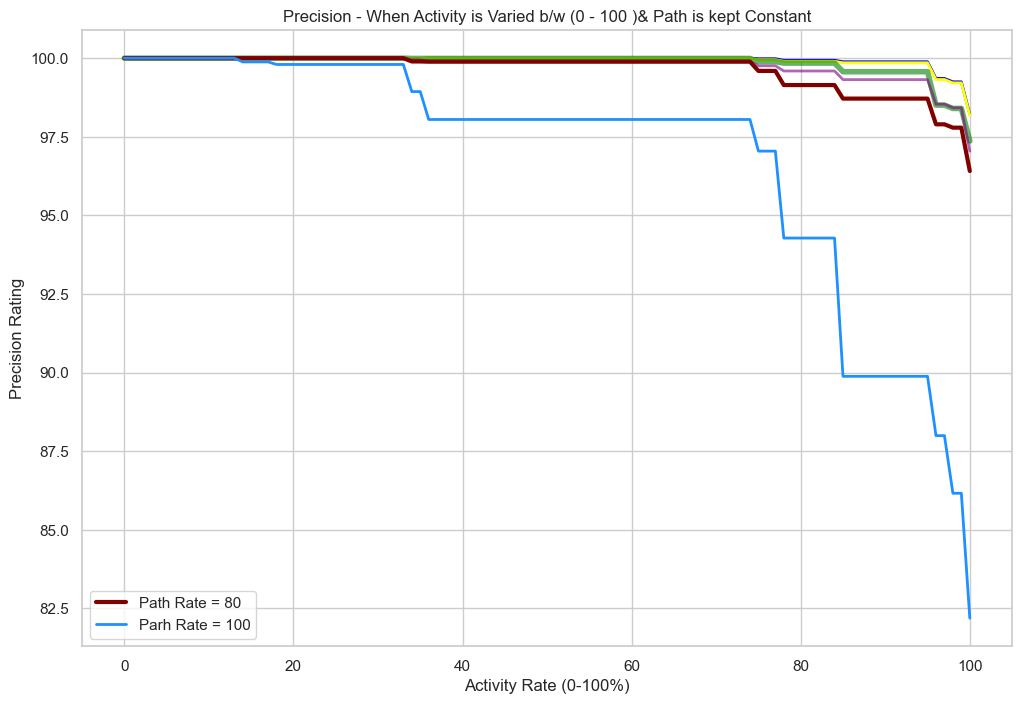

In [22]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA0, lw = 2, color = 'blue')
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA1, lw = 2, color = 'yellow')
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Path_Rate', y='Precision', data=res_PA5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Activity Rate (0-100%)")
plt.ylabel("Precision Rating")
plt.title("Precision - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

## ACTIVITIY CONST NOW

In [8]:
ACT = []
#PATH = []
PREC_FINAL = []

ACT_THRES = [5,20,40,60,80,100]

for holy_j in trange(len(ACT_THRES)):
    
    ACT = []
    #PATH = []
    PREC_FINAL = []
    
    INDI_FIT = []
    fitter = 0
    
    
    THE_FATHERLOAD = []
    
    COV_COV = 0
    ID = []
    LOG_LEN = []
    MAP_LEN = []
    FIT_STS = []
    COV_MAP = []
    
    
    for count in trange(0,101,1): #101
        
        keys = [] # To store Initial keys 
    
        mainkey = [] # Source Keys
        subkey = [] # Destination Keys 
        
        startindex = 0 # To store START keyword index
        endindex = 0 # To store END keyword Index
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Net Assignment 
        INPUT = MINER(df1, ACT_THRES[holy_j], count)#count # The Process MAP that is to be compared is entered here (Dataset is entered here)
        #------------------------------------------------------------------------------------------------------------------------
    
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Assigning key to main List 
        for key in INPUT:
            #print(key)
            keys.append(key)
        #-------------------------------------------------------------------------------------------------------------------------
        
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Key Segregation 
        for i in range(len(keys)):
            T1 = keys[i]
            T2 = inner_Filter(T1)
            T3 = T2.split(' ')
            mainkey.append(T3[0])
            subkey.append(T3[1])  
        #-------------------------------------------------------------------------------------------------------------------------
    
        
        #-------------------------------------------------------------------------------------------------------------------------    
        
        # DELETION of START & END Keyword
        
        mainkey, subkey = START_END_DEL(mainkey,subkey)
    #-------------------------------------------------------------------------------------------------------------------------
        
        if mainkey != []:
    
    #-------------------------------------------------------------------------------------------------------------------------
            t_i = mainkey[0]
            k=0
            a = collections.defaultdict(list)

            while k < len(mainkey):
                # dynamically create key
                if k == 0:
                    key = mainkey[k]

                if t_i == mainkey[k]:
                    value = subkey[k]
                    a[key].append(value)
                    k+=1
                else:
                    if t_i != mainkey[k]:
                        t_i = mainkey[k]
                        key = mainkey[k]
                        value = subkey[k]
                        a[key].append(value)
                        k+=1
        #-------------------------------------------------------------------------------------------------------------------------
        # 'a' is the variable which stores the INFO about connections

        #-------------------------------------------------------------------------------------------------------------------------
           # The MODEL REMAINS THE PAME THROHGOUT BUT THE TRACES & DATA LOGS CHANGE THROUGH OUT.
            # CHECKING THAT EACH TRACE FITS WITHIN THE PROCESS MODEL
                # Creation of the MATRIX FROM 
            T = []
            T = pd.DataFrame(mainkey) # The ROWS
            TT = T[0].unique()
            TT.tolist()# FROM  SOURCE

            Q = []
            Q = pd.DataFrame(subkey) # COLUMNS
            QQ = Q[0].unique()
            QQ.tolist() # DESTINATION FINAL

            # Matrix is created here & RESET
            d = 0
            d = pd.DataFrame(0, index = char_sorter(TT), columns=char_sorter(QQ)) # Initialzing Matrix 
                # Accessing the Matrix d.loc["a","a"]



                # Entering the Values to the Matrix
            keyer = list(a.keys()) # SOURCE - FROM # USING A Here

            for ii in range(len(a)):
                for jj in range(len(a[keyer[ii]])):        
                    d.loc[keyer[ii], a[keyer[ii]][jj]] = 1       



                # A Python program to print all 



            #keyer = list(a.keys()) # SOURCE - FROM
            #COMPARE = ""
            COMPARE2 = ""
            #COMPARE3 = ""


            for ii in range(len(d.index)):
                for jj in range(len(d.columns)):
                                if d.loc[d.index[ii], d.columns[jj]] == 1:
                                    #print(d.index[ii], d.columns[jj])
                                    #COMPARE = COMPARE + d.index[ii] + d.columns[jj]
                                    COMPARE2 = COMPARE2 + d.index[ii] + d.columns[jj] + " "
                                    #COMPARE = COMPARE + d.index[ii] + d.columns[jj] + ""

            COMPARE2 = COMPARE2.upper()
            COMPARE2_1 = pd.DataFrame(list(COMPARE2.split(" ")))
            CC = COMPARE2_1[0].unique()

            index = np.argwhere(CC=="")
            CC = np.delete(CC,index)


        #-------------------------------------------------------------------------------------------------------------------------
        # The Process Model is compared with each Trace and the final Precision is calculated per trace vs the Overall Process model
        # This is because we use the Generalized Process model and not Individual in this case


            final_state = 0 # SHOULD BE REFRESHED FOR EVERY ITERATION OF THE PROCESS MODEL (i.e. every new process map & not every ID)
            SUM_PREC = 0

            test_id = []
            test_PREC = []

            creation5 = []
            COMBI5 = []

            for s in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID

                df3 = df1[df1["case_id"]== ids[s]].reset_index(drop = True)

                trace = df3.copy() # ID CARRYING VARIABLE



                    # LOG
            # Creation of Synthetic Paris for Comparison
            ### The pairs here are created using the DATA LOG = Directly from the Data Logs and not the 

                # INDEPENDENT OF ANY OTHER CALCULATIONS

                ###  First Combo EVEN COMBO 

            # WHOLE AS A UNIT

                creation2 = ""

                for kk in range(1, len(trace["task"]),2):
                    #print(df1["task"][kk-1], df1["task"][kk])
                    creation2 = creation2+trace["task"][kk-1]+trace["task"][kk]+" "

                F = pd.DataFrame(list(creation2.split(" ")))
                #len(F[0].unique())
                COMBI2 = F[0].unique() # FIRST PAIR COMBO 


                ### Second Combo ODD COMBO

                creation3 = ""

                for kk in range(1, len(trace["task"])-1,2):
                    #print(df1["task"][kk-1], df1["task"][kk])
                    creation3 = creation3+trace["task"][kk]+trace["task"][kk+1]+" "

                C = pd.DataFrame(list(creation3.split(" ")))
                #len(C[0].unique())
                COMBI3 = C[0].unique()

                # Combining both
                creation4 = np.concatenate((COMBI2,COMBI3))
                M = pd.DataFrame(list(creation4))
                COMBI4 = M[0].unique()


                index = np.argwhere(COMBI4=="")
                COMBI4 = np.delete(COMBI4,index)


                index = np.argwhere(COMBI4=="")
                COMBI4 = np.delete(COMBI4,index)


                #COMBI5.append(COMBI4)

                for gg in range(len(COMBI4)):
                    creation5.append(COMBI4[gg])

                GG = pd.DataFrame(creation5)
                COMBI5 = GG[0].unique()

        #del creation5
        #del GG

                PRECISION = 1-len(np.setdiff1d(CC, COMBI5))/len(COMBI5)
                #print(np.setdiff1d(CC, COMBI5))
                #PRECISION = abs(1-(len(np.setdiff1d(CC, COMBI4))/len(COMBI4))) # FIRST ARRAY (BIG SIZE), SECOND ARRAY( COMPARING VARIABLE`)

                #if PRECISION >=1.0:
                #    PRECISION = 1.0

                SUM_PREC = PRECISION + SUM_PREC

                #print("ID :", ids[s] ,"MAIN VALUE : ", len(np.setdiff1d(CC, COMBI4)), "COMBI4",len(COMBI4),"Precision = ", PRECISION, "Activity = ", count , "Path = 100")

                #test_id.append(ids[s])
                #test_PREC.append(PRECISION)




            print("TOTAL PREICION FOR ABOVE =", (SUM_PREC/len(ids))*100)
            PREC_FINAL.append((SUM_PREC/len(ids))*100)
            ACT.append(count)
            #ACT.append(count)
        else:
            ACT.append(count)
            PREC_FINAL.append(0)            
        
        
    
        print("\n\n-----------------------------------------------------------------------------------------")                   
        print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")      
            # ADD THE REMANING CODE FROM EHRE>>>>>
            
    if holy_j == 0:
        res_PP0 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
        #res_af1
        
    elif holy_j == 1:
        res_PP1 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
        #res_af1
    
    elif holy_j == 2:
        res_PP2 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
    
    elif holy_j == 3:
        res_PP3 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
    
    elif holy_j == 4:
        res_PP4 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
    
    elif holy_j == 5:
        res_PP5 = pd.DataFrame({"Activity_Rate":ACT,"Precision":PREC_FINAL})
    
    
PATH_FULL = res_PP0.copy()
PATH_FULL = PATH_FULL.merge(res_PP1, on='Activity_Rate', how='right')
PATH_FULL = PATH_FULL.merge(res_PP2, on='Activity_Rate', how='right')
PATH_FULL = PATH_FULL.merge(res_PP3, on='Activity_Rate', how='right')
PATH_FULL = PATH_FULL.merge(res_PP4, on='Activity_Rate', how='right')
PATH_FULL = PATH_FULL.merge(res_PP5, on='Activity_Rate', how='right')

PATH_FULL.columns = ['Path_Rate', 'Activity = 5', 'Activity = 20' ,'Activity = 40', 'Activity = 60','Activity = 80','Activity = 100']

PATH_FULL
        

{'activities': 5, 'paths': 0}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 1}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 2}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 3}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 34}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 35}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 36}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 37}
TOTAL PR

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 68}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 69}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 70}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 71}
TOTAL PR

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 1}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 2}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 3}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 4}
TOTAL PR

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 34}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 35}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 36}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 37}
TOTA

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 67}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 68}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 69}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 70}
TOTA

TOTAL PREICION FOR ABOVE = 99.89433761877635


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 20, 'paths': 100}
TOTAL PREICION FOR ABOVE = 99.79961260251112


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 0}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 1}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities'

TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 32}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 33}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 34}
TOTAL PREICION FOR ABOVE = 99.99080882352942


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 64}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 65}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 66}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.2044818999874


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 96}
TOTAL PREICION FOR ABOVE = 99.16799271414915


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 97}
TOTAL PREICION FOR ABOVE = 98.98588947290101


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 40, 'paths': 98}
TOTAL PREICION FOR ABOVE = 98.80378623165288


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-----------------------------

TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 28}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 29}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 30}
TOTAL PREICION FOR ABOVE = 100.0


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 31}
TOTA

TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 60}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 61}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 62}
TOTAL PREICION FOR ABOVE = 99.89732705818771


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.45909027976022


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 92}
TOTAL PREICION FOR ABOVE = 99.33975322134864


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 93}
TOTAL PREICION FOR ABOVE = 99.2044818999874


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 60, 'paths': 94}
TOTAL PREICION FOR ABOVE = 99.2044818999874


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE------------------------------

TOTAL PREICION FOR ABOVE = 99.90073529411765


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 23}
TOTAL PREICION FOR ABOVE = 99.90073529411765


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 24}
TOTAL PREICION FOR ABOVE = 99.90073529411765


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 25}
TOTAL PREICION FOR ABOVE = 99.90073529411765


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 99.74709677376626


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 55}
TOTAL PREICION FOR ABOVE = 99.74709677376626


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 56}
TOTAL PREICION FOR ABOVE = 99.74709677376626


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 57}
TOTAL PREICION FOR ABOVE = 99.71060758792798


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE----------------------------

TOTAL PREICION FOR ABOVE = 98.36114325335804


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 87}
TOTAL PREICION FOR ABOVE = 98.25320961995283


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 88}
TOTAL PREICION FOR ABOVE = 98.20540821692


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 80, 'paths': 89}
TOTAL PREICION FOR ABOVE = 98.17135062917028


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------

TOTAL PREICION FOR ABOVE = 98.180053646719


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 18}
TOTAL PREICION FOR ABOVE = 98.61322772156758


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 19}
TOTAL PREICION FOR ABOVE = 98.61322772156758


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 20}
TOTAL PREICION FOR ABOVE = 98.61322772156758


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE---------------------------

TOTAL PREICION FOR ABOVE = 98.10435648737183


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 50}
TOTAL PREICION FOR ABOVE = 98.10435648737183


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 51}
TOTAL PREICION FOR ABOVE = 97.7024599893967


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 52}
TOTAL PREICION FOR ABOVE = 97.7024599893967


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE---------------------------

TOTAL PREICION FOR ABOVE = 96.44321387560208


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 82}
TOTAL PREICION FOR ABOVE = 95.8683077177897


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 83}
TOTAL PREICION FOR ABOVE = 95.76455189187111


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 100, 'paths': 84}
TOTAL PREICION FOR ABOVE = 95.28803850507805


-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE--------------------------

C:\Users\ashis\AppData\Local\Temp\ipykernel_39812\3106954246.py:315: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Precision_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_PP3, on='Activity_Rate', how='right')
C:\Users\ashis\AppData\Local\Temp\ipykernel_39812\3106954246.py:317: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Precision_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_PP5, on='Activity_Rate', how='right')


,Path_Rate,Activity = 5,Activity = 20,Activity = 40,Activity = 60,Activity = 80,Activity = 100
0,0,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
1,1,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
2,2,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
3,3,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
4,4,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
5,5,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
6,6,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
7,7,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
8,8,100.0,100.000000,100.000000,100.000000,99.933824,98.213142
9,9,100.0,100.000000,100.000000,100.000000,99.933824,98.213142


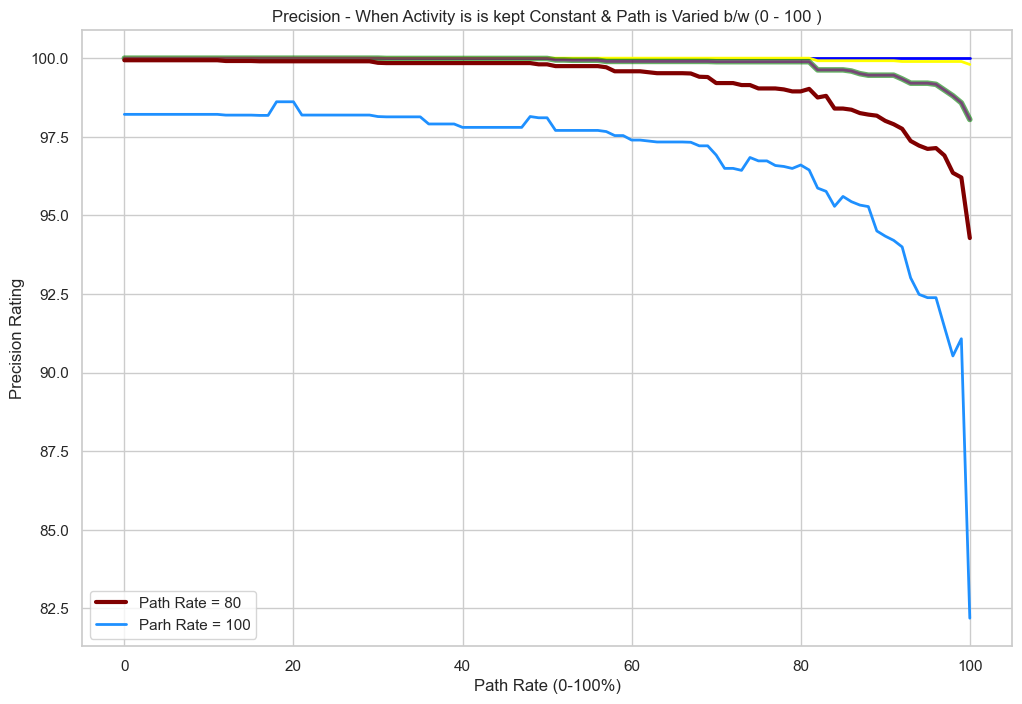

In [9]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP0, lw = 2, color = 'blue')
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP1, lw = 2, color = 'yellow')
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Activity_Rate', y='Precision', data=res_PP5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Path Rate (0-100%)")
plt.ylabel("Precision Rating")
plt.title("Precision - When Activity is is kept Constant & Path is Varied b/w (0 - 100 )")
plt.show()

In [ ]:
PATH_FULL.to_csv("Sample_5_Precision_PATH.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(Path_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Path is kept Constant & Varied b/w (0 - 100 )")
plt.show()